# [3주차] 심화과제 - Pre-trained 모델로 효율적인 NLP 모델 학습하기

#### Q1) 어떤 task를 선택하셨나요?
- MNLI task
- MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제이다.
- BERT는 sentence pair classification에 특화되어 있어 MNLI와 같이 두 문장 간의 복잡한 의미 관계를 파악하는데 효과적이다. BERT와 비슷한 성능을 가지면서 사이즈는 작은 DistilBERT를 사용하였다.

#### Q2) 모델은 어떻게 설계하셨나요? 설계한 모델의 입력과 출력 형태가 어떻게 되나요?
- 아래 출력 포함


#### Q3) 실제로 pre-trained 모델을 fine-tuning했을 때 loss curve은 어떻게 그려지나요? 그리고 pre-train 하지 않은 Transformer를 학습했을 때와 어떤 차이가 있나요?




In [1]:
%pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

### 1. 데이터셋 준비

Kaggle 데이터셋을 다운로드 받는다.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


kaggle 데이터셋은 다음과 같이 구성되어 있다.
- premise: 기준이 되는 첫 번째 문장
- hypothesis: 두 번째 문장
- label: 두 문장의 관계
  - entailment: 논리적 연결(0)
  - contradiction: 모순 관계(1)
  - neutral: 무관한 관계(2)

In [3]:
import random
import pandas as pd

def load_data(path, nrows=None):
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data

# 경로 : load_data(path + '/불러올파일명.csv', nrows=1000)
train_data = load_data(path+'/train.csv', nrows=1000)
test_data = load_data(path+'/validation_matched.csv', nrows=1000)

DistilBERT 모델용 tokenizer를 불러온다.

In [4]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


max length를 설정하기 위해 문장의 길이 분포를 확인한다.

train data의 99% 이상이 103 이하이고, test data의 99% 이상이 94 이하이다.

트랜스포머 모델은 8의 배수로 처리할 때 효율적이므로 8 X 103 = 104를 max length로 설정한다.

In [5]:
# 문장 길이 분포 확인
def analyze_length_distribution(data):
    premise_lengths = []
    hypothesis_lengths = []
    total_lengths = []

    # 각 문장을 토큰화하여 길이 계산
    for item in data:
        premise_tokens = tokenizer(item['premise'])['input_ids']
        hypothesis_tokens = tokenizer(item['hypothesis'])['input_ids']

        premise_len = len(premise_tokens)
        hypothesis_len = len(hypothesis_tokens)
        # BERT/DistilBERT는 두 문장을 [CLS] premise [SEP] hypothesis [SEP] 형태로 결합
        # 따라서 총 길이는 premise + hypothesis + 3 ([CLS]와 [SEP] 토큰)
        total_len = premise_len + hypothesis_len + 3

        premise_lengths.append(premise_len)
        hypothesis_lengths.append(hypothesis_len)
        total_lengths.append(total_len)

    print(f"=== 길이 통계 ===")
    print(f"Premise 평균 길이: {sum(premise_lengths)/len(premise_lengths):.1f}")
    print(f"Premise 최대 길이: {max(premise_lengths)}")
    print(f"Hypothesis 평균 길이: {sum(hypothesis_lengths)/len(hypothesis_lengths):.1f}")
    print(f"Hypothesis 최대 길이: {max(hypothesis_lengths)}")
    print(f"전체 시퀀스 평균 길이: {sum(total_lengths)/len(total_lengths):.1f}")
    print(f"전체 시퀀스 최대 길이: {max(total_lengths)}")

    # 90, 95, 99 퍼센타일 계산
    percentiles = [90, 95, 99]
    for p in percentiles:
        threshold = sorted(total_lengths)[int(len(total_lengths) * p/100)]
        print(f"{p}% 문장의 길이: {threshold} 이하")

print("Training Data 분석:")
analyze_length_distribution(train_data)
print("\nTest Data 분석:")
analyze_length_distribution(test_data)

Training Data 분석:
=== 길이 통계 ===
Premise 평균 길이: 26.9
Premise 최대 길이: 189
Hypothesis 평균 길이: 14.1
Hypothesis 최대 길이: 49
전체 시퀀스 평균 길이: 44.1
전체 시퀀스 최대 길이: 215
90% 문장의 길이: 67 이하
95% 문장의 길이: 77 이하
99% 문장의 길이: 103 이하

Test Data 분석:
=== 길이 통계 ===
Premise 평균 길이: 25.4
Premise 최대 길이: 138
Hypothesis 평균 길이: 14.1
Hypothesis 최대 길이: 46
전체 시퀀스 평균 길이: 42.5
전체 시퀀스 최대 길이: 165
90% 문장의 길이: 65 이하
95% 문장의 길이: 74 이하
99% 문장의 길이: 94 이하


In [6]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader


def collate_fn(batch):
    premises, hypotheses, labels = [], [], []

    # 배치 내 각 샘플에서 premise, hypothesis, label 추출
    for row in batch:
        premises.append(row['premise'])
        hypotheses.append(row['hypothesis'])
        labels.append(row['label'])

    # tokenizer로 두 문장을 함께 토큰화
    encoded = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation=True,
        max_length=104,
        # PyTorch 텐서로 변환하여 반환한다.
        return_tensors='pt'
    )

    # label을 텐서로 변환한다
    labels = torch.LongTensor(labels)

    # 모델 입력에 필요한 모든 정보 반환
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': labels
    }

batch_size = 16

# DataLoader 설정
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# 데이터 형태 확인
for batch in train_loader:
    print("배치 크기:", batch['input_ids'].shape)
    print("어텐션 마스크 크기:", batch['attention_mask'].shape)
    print("라벨 크기:", batch['labels'].shape)
    print("\n첫 번째 배치 예시:")
    print("입력 ID:", batch['input_ids'][0])
    print("라벨:", batch['labels'][0])
    break

배치 크기: torch.Size([16, 70])
어텐션 마스크 크기: torch.Size([16, 70])
라벨 크기: torch.Size([16])

첫 번째 배치 예시:
입력 ID: tensor([  101,  2002,  2001,  3015,  1037,  5432,  1010,  2025,  1037, 20422,
         1012,   102,  1996,  2610,  2961,  2001,  3015,  1037,  5432,  7281,
         1010,  2025,  1037, 20422,  2013,  1037,  3460,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
라벨: tensor(1)


### 2. 모델 정의

MNLI task를 위해 시퀀스 분류용 모델 DistilBertForSequenceClassification을 불러온다.

DistilBertForSequenceClassification은 기본 DistillBERT에 분류를 위한 선형 레이어가 추가되어 있다.

In [7]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3, # entailment, contradiction, neutral
    dropout=0.3
)

# GPU를 사용하기 위한 옵션
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델의 입력과 출력, 예측 결과 형태를 확인한다.

In [8]:
# 예시 데이터
premise = "Conceptually cream skimming has two basic dimensions - product and geography."
hypothesis = "Product and geography are what make cream skimming work."

# 입력 형태
encoded = tokenizer(
    premise,
    hypothesis,
    padding=True,
    truncation=True,
    max_length=104,
    return_tensors='pt'
)
encoded = {k: v.to(device) for k, v in encoded.items()}

print("=== 입력 형태 ===")
print("input_ids 형태:", encoded['input_ids'].shape)
print("attention_mask 형태:", encoded['attention_mask'].shape)

# 모델 출력
outputs = model(**encoded)
print("\n=== 출력 형태 ===")
print("로짓 형태:", outputs.logits.shape)  # [batch_size, 3] - 3개 클래스에 대한 점수

# 예측 클래스
predicted_class = torch.argmax(outputs.logits, dim=1)
print("\n=== 예측 결과 ===")
print("예측 클래스:", predicted_class.item())  # 0: entailment, 1: contradiction, 2: neutral

# 레이블과 예측값 매핑
label_map = {0: 'entailment', 1: 'contradiction', 2: 'neutral'}
print("예측 결과:", label_map[predicted_class.item()])

=== 입력 형태 ===
input_ids 형태: torch.Size([1, 28])
attention_mask 형태: torch.Size([1, 28])

=== 출력 형태 ===
로짓 형태: torch.Size([1, 3])

=== 예측 결과 ===
예측 클래스: 0
예측 결과: entailment


### 3. Fine tuning

fine tuning 전/후를 비교하기 위해 정확도를 계산하고 모델의 성능을 평가하는 함수를 추가한다.

In [9]:
# 정확도 계산 함수
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

# 모델 성능 평가 및 시각화 함수
def evaluate_and_visualize(model, train_loader, test_loader, title_prefix=""):
    # 정확도 계산
    train_acc = compute_accuracy(model, train_loader)
    test_acc = compute_accuracy(model, test_loader)

    print(f"\n=== {title_prefix} 모델 성능 ===")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return train_acc, test_acc

overfitting을 방지하기 위해 early stopping을 정의한다.

In [10]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, verbose=True):
        """
        patience: 성능 향상이 없어도 기다리는 에폭 수
        min_delta: 성능 향상으로 간주할 최소 변화량
        verbose: 상세 출력 여부
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_acc = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, val_acc, model):
        if self.best_loss is None:  # 첫 에폭
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:  # 성능 향상이 없는 경우
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early stopping triggered! Best accuracy: {self.best_acc:.4f}')
        else:  # 성능이 향상된 경우
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model = model.state_dict()
            self.counter = 0

학습 함수를 정의한다.

In [11]:
import torch
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 학습 함수
def train_model(model, train_loader, test_loader):
    model = model.to(device)

    # transformer 미세조정에 적합한 learning rate
    lr = 2e-5
    n_epochs = 50

    # AdamW 옵티마이저 사용 (트랜스포머 모델에 더 적합)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Early Stopping 초기화
    early_stopping = EarlyStopping(
        patience=3,  # 3번 연속으로 성능 향상이 없으면 중단
        min_delta=0.001,  # 최소 0.1%p 향상을 기대
        verbose=True
    )

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}')

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 에폭마다 정확도 계산
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        print(f"Total Loss: {total_loss:.4f}")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}\n")

        # Early Stopping 체크
        early_stopping(avg_loss, test_acc, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            # 최고 성능 모델로 복원
            model.load_state_dict(early_stopping.best_model)
            break

    return train_losses, train_accs, test_accs

fine tuning 전/후 성능을 측정한다.


=== Fine-tuning 전 모델 성능 ===
Train Accuracy: 0.3390
Test Accuracy: 0.3100

=== Fine-tuning 시작 ===


Epoch 1/50: 100%|██████████| 63/63 [00:02<00:00, 23.02it/s, loss=1.12]



Epoch 1/50
Total Loss: 69.0989
Average Loss: 1.0968
Train Accuracy: 0.3900
Test Accuracy: 0.3420



Epoch 2/50: 100%|██████████| 63/63 [00:02<00:00, 24.38it/s, loss=1.06]



Epoch 2/50
Total Loss: 68.3875
Average Loss: 1.0855
Train Accuracy: 0.3840
Test Accuracy: 0.3410



Epoch 3/50: 100%|██████████| 63/63 [00:02<00:00, 25.36it/s, loss=1.05]



Epoch 3/50
Total Loss: 68.4075
Average Loss: 1.0858
Train Accuracy: 0.4090
Test Accuracy: 0.3500

EarlyStopping counter: 1 out of 3


Epoch 4/50: 100%|██████████| 63/63 [00:02<00:00, 26.45it/s, loss=1.12]



Epoch 4/50
Total Loss: 68.2506
Average Loss: 1.0833
Train Accuracy: 0.4130
Test Accuracy: 0.3500



Epoch 5/50: 100%|██████████| 63/63 [00:02<00:00, 25.57it/s, loss=1.11]



Epoch 5/50
Total Loss: 68.2377
Average Loss: 1.0831
Train Accuracy: 0.4220
Test Accuracy: 0.3540

EarlyStopping counter: 1 out of 3


Epoch 6/50: 100%|██████████| 63/63 [00:02<00:00, 25.62it/s, loss=1.03]



Epoch 6/50
Total Loss: 68.0762
Average Loss: 1.0806
Train Accuracy: 0.4260
Test Accuracy: 0.3560



Epoch 7/50: 100%|██████████| 63/63 [00:02<00:00, 26.16it/s, loss=1.2]



Epoch 7/50
Total Loss: 68.0542
Average Loss: 1.0802
Train Accuracy: 0.4360
Test Accuracy: 0.3550

EarlyStopping counter: 1 out of 3


Epoch 8/50: 100%|██████████| 63/63 [00:02<00:00, 26.65it/s, loss=1.04]



Epoch 8/50
Total Loss: 67.8374
Average Loss: 1.0768
Train Accuracy: 0.4380
Test Accuracy: 0.3510



Epoch 9/50: 100%|██████████| 63/63 [00:02<00:00, 26.48it/s, loss=1.02]



Epoch 9/50
Total Loss: 67.6495
Average Loss: 1.0738
Train Accuracy: 0.4390
Test Accuracy: 0.3510



Epoch 10/50: 100%|██████████| 63/63 [00:02<00:00, 25.87it/s, loss=1.03]



Epoch 10/50
Total Loss: 67.3552
Average Loss: 1.0691
Train Accuracy: 0.4410
Test Accuracy: 0.3530



Epoch 11/50: 100%|██████████| 63/63 [00:02<00:00, 26.78it/s, loss=1.12]



Epoch 11/50
Total Loss: 67.4466
Average Loss: 1.0706
Train Accuracy: 0.4360
Test Accuracy: 0.3550

EarlyStopping counter: 1 out of 3


Epoch 12/50: 100%|██████████| 63/63 [00:02<00:00, 25.85it/s, loss=1.05]



Epoch 12/50
Total Loss: 67.0913
Average Loss: 1.0649
Train Accuracy: 0.4460
Test Accuracy: 0.3580



Epoch 13/50: 100%|██████████| 63/63 [00:02<00:00, 27.15it/s, loss=1.04]



Epoch 13/50
Total Loss: 66.9906
Average Loss: 1.0633
Train Accuracy: 0.4480
Test Accuracy: 0.3620



Epoch 14/50: 100%|██████████| 63/63 [00:02<00:00, 26.79it/s, loss=1.14]



Epoch 14/50
Total Loss: 66.6188
Average Loss: 1.0574
Train Accuracy: 0.4480
Test Accuracy: 0.3640



Epoch 15/50: 100%|██████████| 63/63 [00:02<00:00, 27.20it/s, loss=1.03]



Epoch 15/50
Total Loss: 66.9182
Average Loss: 1.0622
Train Accuracy: 0.4540
Test Accuracy: 0.3680

EarlyStopping counter: 1 out of 3


Epoch 16/50: 100%|██████████| 63/63 [00:02<00:00, 26.37it/s, loss=1.07]



Epoch 16/50
Total Loss: 66.5928
Average Loss: 1.0570
Train Accuracy: 0.4560
Test Accuracy: 0.3660

EarlyStopping counter: 2 out of 3


Epoch 17/50: 100%|██████████| 63/63 [00:02<00:00, 26.53it/s, loss=1.01]



Epoch 17/50
Total Loss: 66.1293
Average Loss: 1.0497
Train Accuracy: 0.4540
Test Accuracy: 0.3650



Epoch 18/50: 100%|██████████| 63/63 [00:02<00:00, 26.69it/s, loss=1]



Epoch 18/50
Total Loss: 66.2508
Average Loss: 1.0516
Train Accuracy: 0.4660
Test Accuracy: 0.3700

EarlyStopping counter: 1 out of 3


Epoch 19/50: 100%|██████████| 63/63 [00:02<00:00, 25.23it/s, loss=0.964]



Epoch 19/50
Total Loss: 66.3339
Average Loss: 1.0529
Train Accuracy: 0.4670
Test Accuracy: 0.3670

EarlyStopping counter: 2 out of 3


Epoch 20/50: 100%|██████████| 63/63 [00:02<00:00, 26.78it/s, loss=1.02]



Epoch 20/50
Total Loss: 65.9737
Average Loss: 1.0472
Train Accuracy: 0.4640
Test Accuracy: 0.3720



Epoch 21/50: 100%|██████████| 63/63 [00:02<00:00, 25.45it/s, loss=1.04]



Epoch 21/50
Total Loss: 65.9135
Average Loss: 1.0462
Train Accuracy: 0.4630
Test Accuracy: 0.3710

EarlyStopping counter: 1 out of 3


Epoch 22/50: 100%|██████████| 63/63 [00:02<00:00, 27.05it/s, loss=1.04]



Epoch 22/50
Total Loss: 65.8547
Average Loss: 1.0453
Train Accuracy: 0.4770
Test Accuracy: 0.3720



Epoch 23/50: 100%|██████████| 63/63 [00:02<00:00, 26.69it/s, loss=0.992]



Epoch 23/50
Total Loss: 65.5833
Average Loss: 1.0410
Train Accuracy: 0.4770
Test Accuracy: 0.3670



Epoch 24/50: 100%|██████████| 63/63 [00:02<00:00, 26.57it/s, loss=1.02]



Epoch 24/50
Total Loss: 65.6435
Average Loss: 1.0420
Train Accuracy: 0.4850
Test Accuracy: 0.3820

EarlyStopping counter: 1 out of 3


Epoch 25/50: 100%|██████████| 63/63 [00:02<00:00, 26.57it/s, loss=0.987]



Epoch 25/50
Total Loss: 65.7798
Average Loss: 1.0441
Train Accuracy: 0.4940
Test Accuracy: 0.3810

EarlyStopping counter: 2 out of 3


Epoch 26/50: 100%|██████████| 63/63 [00:02<00:00, 25.88it/s, loss=1.03]



Epoch 26/50
Total Loss: 65.4005
Average Loss: 1.0381
Train Accuracy: 0.4890
Test Accuracy: 0.3730



Epoch 27/50: 100%|██████████| 63/63 [00:02<00:00, 26.83it/s, loss=1.05]



Epoch 27/50
Total Loss: 65.4148
Average Loss: 1.0383
Train Accuracy: 0.4960
Test Accuracy: 0.3790

EarlyStopping counter: 1 out of 3


Epoch 28/50: 100%|██████████| 63/63 [00:02<00:00, 25.67it/s, loss=1.14]



Epoch 28/50
Total Loss: 65.2515
Average Loss: 1.0357
Train Accuracy: 0.5060
Test Accuracy: 0.3790



Epoch 29/50: 100%|██████████| 63/63 [00:02<00:00, 26.88it/s, loss=0.958]



Epoch 29/50
Total Loss: 65.0030
Average Loss: 1.0318
Train Accuracy: 0.4930
Test Accuracy: 0.3730



Epoch 30/50: 100%|██████████| 63/63 [00:02<00:00, 26.34it/s, loss=1.09]



Epoch 30/50
Total Loss: 64.8666
Average Loss: 1.0296
Train Accuracy: 0.5030
Test Accuracy: 0.3800



Epoch 31/50: 100%|██████████| 63/63 [00:02<00:00, 26.20it/s, loss=1.09]



Epoch 31/50
Total Loss: 64.7328
Average Loss: 1.0275
Train Accuracy: 0.5030
Test Accuracy: 0.3840



Epoch 32/50: 100%|██████████| 63/63 [00:02<00:00, 26.77it/s, loss=1.05]



Epoch 32/50
Total Loss: 64.6152
Average Loss: 1.0256
Train Accuracy: 0.5230
Test Accuracy: 0.3930



Epoch 33/50: 100%|██████████| 63/63 [00:02<00:00, 26.40it/s, loss=0.897]



Epoch 33/50
Total Loss: 64.3983
Average Loss: 1.0222
Train Accuracy: 0.5190
Test Accuracy: 0.3870



Epoch 34/50: 100%|██████████| 63/63 [00:02<00:00, 26.07it/s, loss=1.04]



Epoch 34/50
Total Loss: 64.5695
Average Loss: 1.0249
Train Accuracy: 0.5090
Test Accuracy: 0.3840

EarlyStopping counter: 1 out of 3


Epoch 35/50: 100%|██████████| 63/63 [00:02<00:00, 25.57it/s, loss=1.06]



Epoch 35/50
Total Loss: 64.3137
Average Loss: 1.0209
Train Accuracy: 0.5240
Test Accuracy: 0.3880



Epoch 36/50: 100%|██████████| 63/63 [00:02<00:00, 26.09it/s, loss=0.978]



Epoch 36/50
Total Loss: 63.9299
Average Loss: 1.0148
Train Accuracy: 0.5110
Test Accuracy: 0.3840



Epoch 37/50: 100%|██████████| 63/63 [00:02<00:00, 25.91it/s, loss=1.09]



Epoch 37/50
Total Loss: 64.0536
Average Loss: 1.0167
Train Accuracy: 0.5300
Test Accuracy: 0.3930

EarlyStopping counter: 1 out of 3


Epoch 38/50: 100%|██████████| 63/63 [00:02<00:00, 26.67it/s, loss=0.97]



Epoch 38/50
Total Loss: 64.0529
Average Loss: 1.0167
Train Accuracy: 0.5390
Test Accuracy: 0.3930

EarlyStopping counter: 2 out of 3


Epoch 39/50: 100%|██████████| 63/63 [00:02<00:00, 27.06it/s, loss=1.06]



Epoch 39/50
Total Loss: 63.7333
Average Loss: 1.0116
Train Accuracy: 0.5310
Test Accuracy: 0.3930



Epoch 40/50: 100%|██████████| 63/63 [00:02<00:00, 26.21it/s, loss=0.877]



Epoch 40/50
Total Loss: 63.7438
Average Loss: 1.0118
Train Accuracy: 0.5300
Test Accuracy: 0.3900

EarlyStopping counter: 1 out of 3


Epoch 41/50: 100%|██████████| 63/63 [00:02<00:00, 27.06it/s, loss=0.829]



Epoch 41/50
Total Loss: 63.4686
Average Loss: 1.0074
Train Accuracy: 0.5230
Test Accuracy: 0.3860



Epoch 42/50: 100%|██████████| 63/63 [00:02<00:00, 26.15it/s, loss=0.986]



Epoch 42/50
Total Loss: 63.3402
Average Loss: 1.0054
Train Accuracy: 0.5300
Test Accuracy: 0.3860



Epoch 43/50: 100%|██████████| 63/63 [00:02<00:00, 26.60it/s, loss=0.805]



Epoch 43/50
Total Loss: 63.3644
Average Loss: 1.0058
Train Accuracy: 0.5410
Test Accuracy: 0.3890

EarlyStopping counter: 1 out of 3


Epoch 44/50: 100%|██████████| 63/63 [00:02<00:00, 25.98it/s, loss=0.821]



Epoch 44/50
Total Loss: 63.0105
Average Loss: 1.0002
Train Accuracy: 0.5370
Test Accuracy: 0.3950



Epoch 45/50: 100%|██████████| 63/63 [00:02<00:00, 26.57it/s, loss=0.833]



Epoch 45/50
Total Loss: 62.7400
Average Loss: 0.9959
Train Accuracy: 0.5390
Test Accuracy: 0.3970



Epoch 46/50: 100%|██████████| 63/63 [00:02<00:00, 25.72it/s, loss=0.929]



Epoch 46/50
Total Loss: 62.8828
Average Loss: 0.9981
Train Accuracy: 0.5400
Test Accuracy: 0.3890

EarlyStopping counter: 1 out of 3


Epoch 47/50: 100%|██████████| 63/63 [00:02<00:00, 26.98it/s, loss=0.801]



Epoch 47/50
Total Loss: 62.6413
Average Loss: 0.9943
Train Accuracy: 0.5310
Test Accuracy: 0.3840



Epoch 48/50: 100%|██████████| 63/63 [00:02<00:00, 26.00it/s, loss=1]



Epoch 48/50
Total Loss: 63.1300
Average Loss: 1.0021
Train Accuracy: 0.5520
Test Accuracy: 0.3960

EarlyStopping counter: 1 out of 3


Epoch 49/50: 100%|██████████| 63/63 [00:02<00:00, 27.43it/s, loss=1.13]



Epoch 49/50
Total Loss: 63.0067
Average Loss: 1.0001
Train Accuracy: 0.5300
Test Accuracy: 0.3920

EarlyStopping counter: 2 out of 3


Epoch 50/50: 100%|██████████| 63/63 [00:02<00:00, 26.71it/s, loss=0.904]



Epoch 50/50
Total Loss: 62.6826
Average Loss: 0.9950
Train Accuracy: 0.5260
Test Accuracy: 0.3910

EarlyStopping counter: 3 out of 3
Early stopping triggered! Best accuracy: 0.3840

Early stopping triggered at epoch 50

=== Fine-tuning 후 모델 성능 ===
Train Accuracy: 0.5260
Test Accuracy: 0.3910


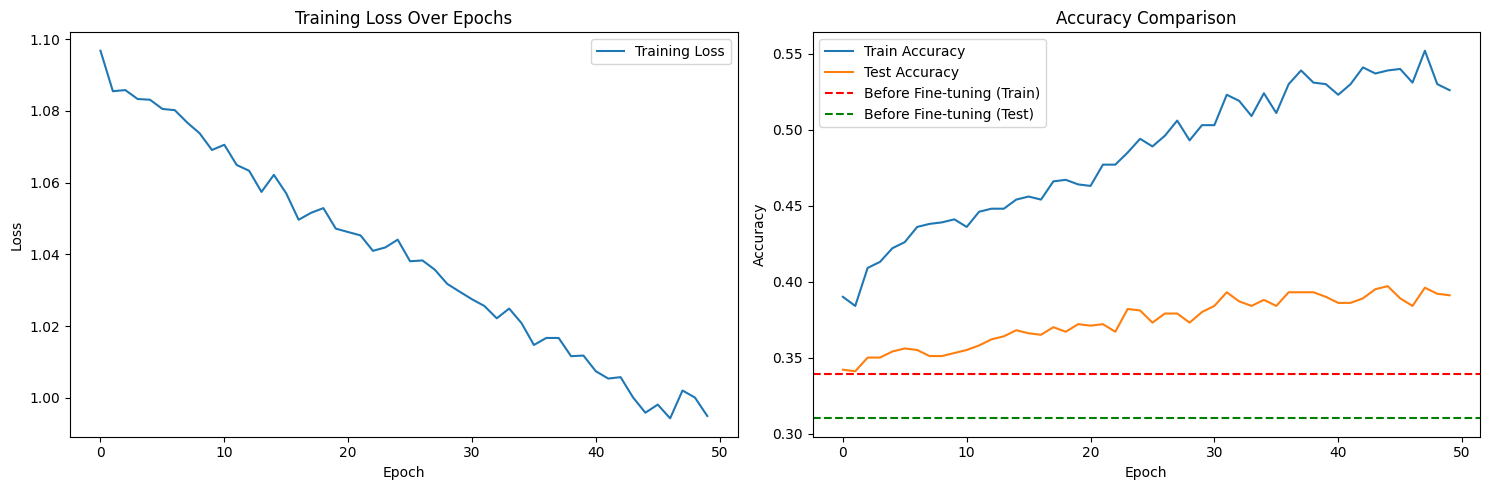


=== 성능 향상 분석 ===
Train Accuracy 향상: 18.70%
Test Accuracy 향상: 8.10%


In [12]:
# 1. Fine-tuning 전 성능 평가
before_train_acc, before_test_acc = evaluate_and_visualize(
    model, train_loader, test_loader, "Fine-tuning 전"
)

# 2. Fine-tuning 수행
print("\n=== Fine-tuning 시작 ===")
for param in model.distilbert.parameters():
    param.requires_grad = False

train_losses, train_accs, test_accs = train_model(
    model, train_loader, test_loader
)

# 3. Fine-tuning 후 성능 평가
after_train_acc, after_test_acc = evaluate_and_visualize(
    model, train_loader, test_loader, "Fine-tuning 후"
)

# 4. 결과 시각화
plt.figure(figsize=(15, 5))

# 학습 중 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.axhline(y=before_train_acc, color='r', linestyle='--', label='Before Fine-tuning (Train)')
plt.axhline(y=before_test_acc, color='g', linestyle='--', label='Before Fine-tuning (Test)')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 향상 출력
print("\n=== 성능 향상 분석 ===")
print(f"Train Accuracy 향상: {(after_train_acc - before_train_acc)*100:.2f}%")
print(f"Test Accuracy 향상: {(after_test_acc - before_test_acc)*100:.2f}%")